In [1]:
import matplotlib.pyplot as plt
import numpy as np
from ase import Atoms
from ase.io import read, write
from ase.visualize import view

import abtem

# Atomic models with ASE
abTEM uses the Atomic Simulation Environment ([ASE](https://wiki.fysik.dtu.dk/ase/)) for creating model atomic structures. ASE is a set of tools and Python modules for setting up, manipulating, visualizing and analyzing atomistic simulations. It is also used in conjunction with other simulation codes such as GPAW for running DFT simulations. Here, we introduce the set of features of ASE needed for image simulations; please refer to the ASE documentation for a more general introduction.

## Atoms
The Atoms object defines a collection of atoms. Here is how to set up an $\mathrm{N}_2$ molecule by directly specifying the position of the two nitrogen atoms (in units of Ångstrom):

In [2]:
n2 = Atoms('2N', positions=[(0., 0., 0.), (0., 0., 1.10)], cell=[2, 2, 2])

A basic abTEM simulation only uses the positional coordinates, atomic numbers and the unit cell for creating electrostatic potentials. 

We access the $xyz$ positions as an $n\times 3$ array, where $n$ is the number of atoms, and the correspondiong atomic numbers below:

In [3]:
n2.positions, n2.numbers

(array([[0. , 0. , 0. ],
        [0. , 0. , 1.1]]),
 array([7, 7]))

The cell can be accessed as below:

In [4]:
n2.cell

Cell([2.0, 2.0, 2.0])

In this example, the unit vectors of the unit cell were all orthogonal and axis-aligned, hence the cell can be given as just the sides of a rectangular cuboid. In general the cell consist of three arbitrary lattice vectors, we show the expanded representation of the cell below, here each row represents a lattice vector.

In [57]:
print(np.array_str(n2.cell))

[[2. 0. 0.]
 [0. 2. 0.]
 [0. 0. 2.]]


```{important}
The multislice algorithm as implemented in `abTEM` always requires that the unit cell is an axis-aligned rectangular cuboid, additionally, the cell must be periodic. Fulfilling both of these constraints, while creating a desired model structure is not always trivial, see [below](orthogonal) for our introduction to the problem.
```

## Import/export

ASE can import all the common atomic structure formats, see a full list [here](https://wiki.fysik.dtu.dk/ase/ase/io/io.html). Below we import a `.cif`-file defining a unit cell of strontium titanate (SrTiO<sub>3</sub>). 

We download a structure file from the [materials project](https://materialsproject.org/). This is an open source library containing a huge number of crystal structures, calculated using density functional theory.

In [9]:
srtio3 = read('data/SrTiO3_mp-5229_conventional_standard.cif')

In [11]:
write('data/srtio3_100.cif', srtio3)

## Visualizing structures
The simplest way to visualize the atoms is the `view` function, which should bring up an interactive 3d viewer:

In [12]:
# may not work in remote environments (e.g. binder)
view(srtio3) 

<Popen: returncode: None args: ['C:\\Users\\jacob\\anaconda3\\envs\\dask-gpu...>

If you are working in a remote environment or prefer to embed the viewer in the notebook, you can install [nglview](https://github.com/nglviewer/nglview). This will allow you to use the `nglview` backend for the `view` function.

In [13]:
# may not work without installing additional dependencies
# view(srtio3, viewer='nglview') 

abTEM provides a simple viewer for embedding a basic visualization in a notebook. This function shows a 2D projection of the structure perpendicular to the specified plane. For example:

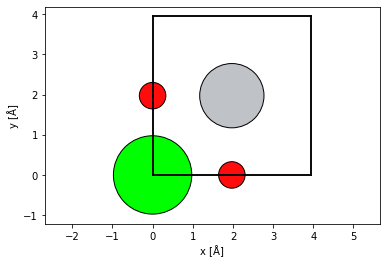

In [14]:
abtem.show_atoms(srtio3, plane='xy');

## Bulding structures

In addition to importing the structure, ASE has tools for procedurally creating certain common structures:

* Common bulk crystals: [`ase.build.bulk`](https://wiki.fysik.dtu.dk/ase/ase/build/build.html#ase.build.bulk)
* Bulk structures by its spacegroup: [`ase.spacegroup.crystal`](https://wiki.fysik.dtu.dk/ase/ase/spacegroup/spacegroup.html?highlight=crystal)
* Carbon nanotubes: [`ase.build.nanotube`](https://wiki.fysik.dtu.dk/ase/ase/build/build.html#nanotubes)
* Nanoparticles: [`ase.cluster`](https://wiki.fysik.dtu.dk/ase/ase/cluster/cluster.html)

As an example, we create a nanotube with a chirality $(6,0)$ nanotube (`length=1` here indicates the minimal commensurate unit cell along the tube axis).

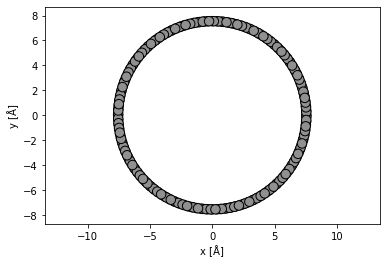

In [15]:
from ase.build import nanotube

cnt = nanotube(14, 8, length=1)

abtem.show_atoms(cnt);

## Manipulating structures

The structure you import or build may not exactly match your requirements or the requirements of abTEM. Here, we exemplify the most common manipulations needed for creating models for image simulation:

### Adding vacuum

The unit cell of the nanotube above has no extent in $xy$.

In [71]:
cnt.cell

Cell([19.099778234172625, 19.099778234172625, 13.693984080609994])

The $xy$ extent of the unit cell determines the extent of the wave function in abTEM hence this is not a valid cell. We can use the center method to add vacuum around the unit cell.

In [72]:
cnt.center(axis=(0, 1), vacuum=2)

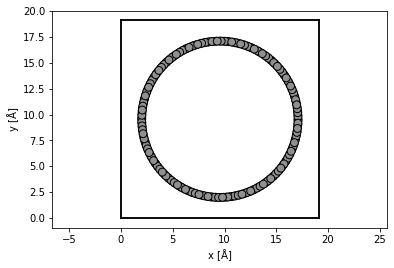

In [73]:
abtem.show_atoms(cnt);

### Rotating structures
A common problem when creating model structures is choosing the image direction. abTEM always assumes that the imaging electrons propagate along the $z$-axis in the direction from negative to positive coordinate values, hence choosing the propagation direction requires manipulating the atomic structure.

In our example above, the electron propagation axis is along the length of the nanotube ($z$), which is not typically what you want. To rotate the nanotube we use the ASE [rotate](https://wiki.fysik.dtu.dk/ase/ase/atoms.html?highlight=atoms#ase.Atoms.rotate) method with the angle given in degrees and the rotation axis.

We first rotate the unit cell along with atoms by $-90 \ \mathrm{deg.}$ around $x$, then we rotate just the atoms around $y$, the new nanotube axis.

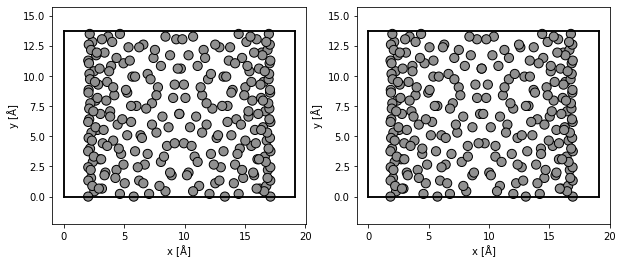

In [70]:
rotated_cnt_a = cnt.copy()

rotated_cnt_a.rotate(-90, 'x', rotate_cell=True)

rotated_cnt_b = rotated_cnt_a.copy()

rotated_cnt_b.rotate(1, 'y')

_, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
abtem.show_atoms(rotated_cnt_a, ax=ax1)
abtem.show_atoms(rotated_cnt_b, ax=ax2);


Rotating the unit cell may leave some cell vectors pointing in a negative direction or permuted in unexpected ways. Hence it is no longer given as just three numbers.

In [63]:
print(np.array_str(rotated_cnt_a.cell, precision=2, suppress_small=True))

[[ 19.1    0.     0.  ]
 [  0.     0.   -19.1 ]
 [  0.    13.69   0.  ]]


We can standardize the cell to get a more easily understandable cell without changing how the structure is parsed by abTEM.

In [65]:
rotated_cnt = abtem.structures.standardize_cell(rotated_cnt_a)

rotated_cnt.cell

Cell([19.09977823417262, 13.693984080609994, 19.099778234172625])

```{warning}
In the example above, we first rotated the structure by 90 degrees, ensuring that the cell was orthogonal and axis-aligned after the transformation. We then rotated it without rotating the cell around $y$, this was only possible because we did not need to preserve the periodicity in $x$ or $z$, the same rotation around $x$ would not be possible without further steps. For such arbitrary rotations, see our introduction to creating orthogonal cells [below](orthogonal).
```

### Picking a zone axis

ASE has the [surface]() function for easily picking a the [zone axis](https://en.wikipedia.org/wiki/Zone_axis) of a given structure by providing the Miller indices.

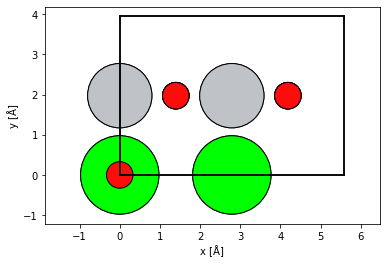

In [94]:
from ase.build import surface

srtio3_110 = surface(srtio3, indices=(1, 1, 0), layers=4, periodic=True)

abtem.show_atoms(srtio3_110, plane='xy');

### Repeating the structure

It is often necessary to repeat the unit cell. You may need to increase the thickness of the structure by repeating it along $z$. In STEM, the $xy$-extent of the model structure have to be large enough to accomodate the size of the probe while preventing self-interaction with its periodic images.

In ASE structures may be repeated by multiplying them.

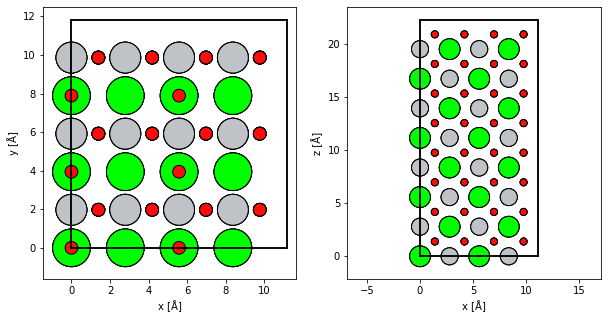

In [95]:
repeated_srtio3 = srtio3_110 * (2, 3, 2)

_, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5))
abtem.show_atoms(repeated_srtio3, ax=ax1)
abtem.show_atoms(repeated_srtio3, ax=ax2, plane='xz');

### Modifying atomic positions and numbers

The atomic positions and numbers are just `numpy` arrays and hence can be modified in-place, as long  .

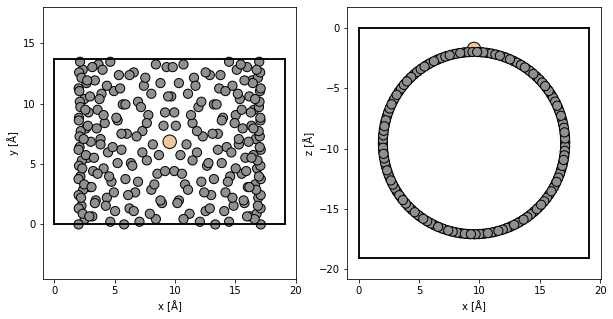

In [96]:
doped_cnt = rotated_cnt_a.copy()

doped_cnt.numbers[186] = 14
doped_cnt.positions[186, 2] = doped_cnt.positions[186, 2] + 0.25

_, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
abtem.show_atoms(doped_cnt, ax=ax1)
abtem.show_atoms(doped_cnt, ax=ax2, plane='xz');

### Conditionally removing atoms

In [98]:
defect_srtio3 = repeated_srtio3.copy()

mask = repeated_srtio3.numbers == 8

mask = mask * (np.random.rand(len(mask)) < .25)

del defect_srtio3[mask]

view(defect_srtio3)

<Popen: returncode: None args: ['C:\\Users\\jacob\\anaconda3\\envs\\dask-gpu...>

### Straining structures



Here, we randomly substitutionally dope the structures by making the titanium atoms into indium atoms with a probability of 10 %.

In [21]:
doped_srtio3 = repeated_srtio3.copy()

mask = doped_srtio3.numbers == 22

mask = mask * (np.random.rand(len(doped_srtio3)) < .1)

doped_srtio3.numbers[mask] = 57

Next, we center the atoms in the cell and add 3 Å of vacuum at the entrance and exit surfaces along the $z$-axis. Note that we visualize the structure now from the side, both along the $y$ and $x$ axes.

### Combining multiple structures



<AxesSubplot:xlabel='x [Å]', ylabel='z [Å]'>

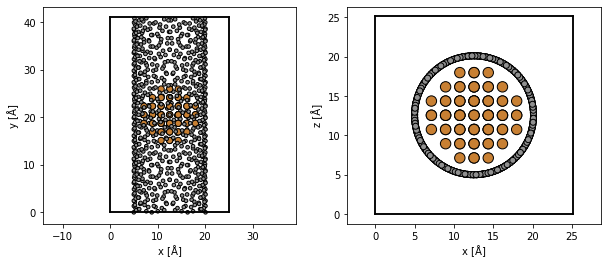

In [93]:
from ase.cluster.cubic import FaceCenteredCubic

surfaces = [(1, 0, 0), (1, 1, 0), (1, 1, 1)]
layers = [3, 4, 2]
lc = 3.61000
nanoparticle = FaceCenteredCubic('Cu', surfaces, layers, latticeconstant=lc)

repeated_cnt = rotated_cnt * (1, 3, 1)

nanoparticle.cell = repeated_cnt.cell
nanoparticle.center()

nanoparticle_in_cnt = repeated_cnt + nanoparticle

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
abtem.show_atoms(nanoparticle_in_cnt, ax=ax1)
abtem.show_atoms(nanoparticle_in_cnt, ax=ax2, plane='xz')

In [99]:
write('data/srtio3_100.cif', repeated_srtio3)

(orthogonal)=
## Orthogonal and periodic supercells

The multislice algorithm requires an orthogonal periodic atomic structure as its input. However, taking any arbitrary structure and making it periodic and orthogonal is not always trivial. abTEM has a tool for solving this problem. To demonstrate the tool, we create a graphene structure with the minimal hexagonal unit cell. 

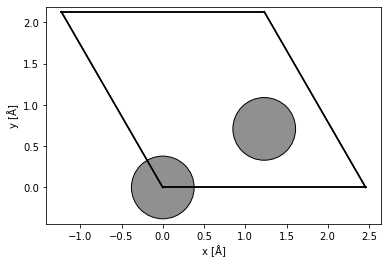

In [28]:
from ase import build

graphene = build.graphene(vacuum=2)

abtem.show_atoms(graphene);

The minimal unit cell of graphene is hexagonal, whereas the multislice algorithm requires an orthogonal unit cell. To make the unit cell orthogonal, we can use the abTEM `orthogonalize_cell` function. It is not always possible to make a periodic cell orthogonal without introducing some strain, hence we can return the strain tensor.

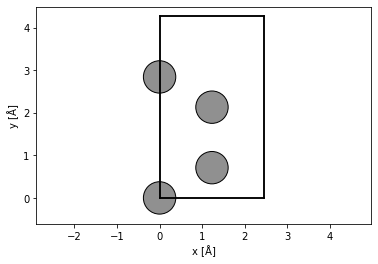

In [100]:
from abtem.structures import orthogonalize_cell, pretty_print_transform

orthogonal_graphene, transform = orthogonalize_cell(graphene, return_transform=True)

abtem.show_atoms(orthogonal_graphene);

Hexagonal cells can be made orthogonal by doubling its size without introducing any strain.

In [30]:
pretty_print_transform(transform)

euler angles (degrees): 	 x = 0.000, 	 y = -0.000, 	 z = 0.000
normal strains (percent): 	 x = 0.000, 	 y = 0.000, 	 z = 0.000
shear strains (percent): 	 xy = 0.000, 	 xz = 0.000, 	 xz = 0.000


A common, less trivial example, is the creation of models with a specific rotation relative to the beam. Here, we want to view FCC gold at a 10 degree angle.

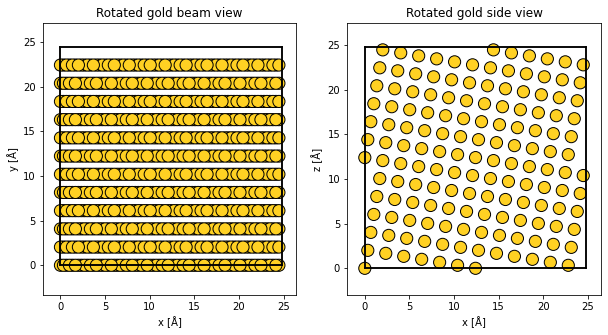

In [31]:
desired_rotation = 10

gold = build.bulk('Au', cubic=True)

gold.rotate(desired_rotation, 'y', rotate_cell=True)

gold, transform = orthogonalize_cell(gold, max_repetitions=10, return_transform=True)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

abtem.show_atoms(gold * (1, 6, 1), ax=ax1, title='Rotated gold beam view')

abtem.show_atoms(gold, ax=ax2, plane='xz', title='Rotated gold side view');

As shown below, creating the rotated structure required an additional rotation of $0.538 \ \mathrm{degrees}$ around the $y$-axis. This means that within the contraint of repeating the structure at most 10 times in either direction, the closest periodic and orthogonal structure is rotated by $10.538 \ \mathrm{degrees}$ and not the desired $10.0 \ \mathrm{degrees}$. This may be close enough, if it is not `max_repetitions` may be increased. For example, within a `max_repetitions` of 20, the required transform is just $-0.008 \ \mathrm{degrees}$ around the $y$-axis.

In [32]:
pretty_print_transform(transform)

euler angles (degrees): 	 x = 0.000, 	 y = 0.538, 	 z = 0.000
normal strains (percent): 	 x = 0.000, 	 y = 0.000, 	 z = -0.000
shear strains (percent): 	 xy = 0.000, 	 xz = 0.000, 	 xz = 0.000
